In [2]:
from uxsim import *
import random
import itertools
from itertools import product
import matplotlib.pyplot as plt
from collections import defaultdict
import time

### Simulation

In [3]:
def oneway(run):

    #--- World Generation ---

    W = World(
        name="",
        deltan=1,
        tmax=3600,
        print_mode=1, save_mode=0, show_mode=1,
        random_seed=run,
        duo_update_time=1
    )

    # network definition
    ave_len = 1.2
    st_len = 1
    cw_len = 0.4

    I1 = W.addNode("I1", 0, 0, signal=[60,60])
    W1 = W.addNode("W1", -ave_len, 0)
    E1 = W.addNode("E1", ave_len, 0)
    N1 = W.addNode("N1", 0, st_len)
    S1 = W.addNode("S1", 0, -st_len)

    IN = W.addNode("IN", 0, cw_len, signal=[60,60])
    IS = W.addNode("IS", 0, -cw_len, signal=[60,60])
    IE = W.addNode("IE", cw_len, 0, signal=[60,60])
    IW = W.addNode("IW", -cw_len, 0, signal=[60,60])

    PNW = W.addNode("PNW", -cw_len, cw_len)
    PNE = W.addNode("PNE", cw_len, cw_len)
    PSW = W.addNode("PSW", -cw_len, -cw_len)
    PSE = W.addNode("PSE", cw_len, -cw_len)

    # STREETS AND AVENUES
    #E <-> W direction: signal group 1
    # avenues
    for n1,n2 in [[W1, I1], [I1, E1]]:
        W.addLink(n1.name+n2.name, n1, n2, length=260, signal_group=1,number_of_lanes = 3,free_flow_speed = 11, jam_density_per_lane = 0.2)

    #N <-> S direction: signal group 0
    # streets
    for n1,n2 in [[N1, I1], [I1, S1]]:
        W.addLink(n1.name+n2.name, n1, n2, length=90, signal_group=0,number_of_lanes = 2,free_flow_speed = 11, jam_density_per_lane = 0.2)

    # PEDESTRIAN CROSS WALK
    #E <-> W direction: signal group 1
    for n1,n2 in [[PNW,IN],[IN,PNE], [PSW,IS],[IS,PSE]]:
        W.addLink(n1.name+n2.name, n1, n2, length=10, signal_group=1,number_of_lanes = 3,free_flow_speed = 1.4, jam_density_per_lane = 1)
        W.addLink(n2.name+n1.name, n2, n1, length=10, signal_group=1,number_of_lanes = 3,free_flow_speed = 1.4, jam_density_per_lane = 1)

    #N <-> S direction: signal group 0
    for n1,n2 in [[PNW,IW],[IW,PSW], [PNE,IE],[IE,PSE]]:
        W.addLink(n1.name+n2.name, n1, n2, length=10, signal_group=0,number_of_lanes = 3,free_flow_speed = 1.4, jam_density_per_lane = 1)
        W.addLink(n2.name+n1.name, n2, n1, length=10, signal_group=0,number_of_lanes = 3,free_flow_speed = 1.4, jam_density_per_lane = 1)

    # === Demand Generation ===

    # VEHICLES
    dt = 30 
    demand_NS = 0.5 # ~15 vehicles / 30 sec
    demand_WE = 1 # ~30 vehicles / 30 sec
    entry_points = {
        W1: (demand_WE, [E1, S1], [0.7,0.3]), # straight, right
        N1: (demand_NS, [S1, E1], [0.8,0.2]), # straight, left
    }
    for origin, (demand, possible_dests, weights) in entry_points.items():
        for t in range(0, 3600, dt):
            dest = random.choices(possible_dests, weights = weights)[0]
            W.adddemand(origin, dest, t, t+dt, random.uniform(demand-0.3, demand))

    # PEDESTRIANS
    demand = 0.4
    entry_points = {
        PNW: (demand, [PNE, PSE, PSW]), 
        PNE: (demand, [PNW, PSE, PSW]),
        PSE: (demand, [PNE, PNW, PSW]),
        PSW: (demand, [PNE, PSE, PNW])
    }
    for origin, (demand, possible_dests) in entry_points.items():
        for t in range(0, 3600, dt):
            dest = random.choice(possible_dests)
            W.adddemand(origin, dest, t, t+dt, random.uniform(0.2, demand))

    # === Run Simulation === 

    H = 3  # Prediction horizon (in time steps)

    # NS pedestirans
    vehicles_at_IE_going_PNE = []
    vehicles_at_IW_going_PNW = []
    vehicles_at_IE_going_PSE = []
    vehicles_at_IW_going_PSW = []

    # EW pedestirans
    vehicles_at_IN_going_PNW = []
    vehicles_at_IN_going_PNE = []
    vehicles_at_IS_going_PSW = []
    vehicles_at_IS_going_PSE = []

    # vehicles
    vehicles_at_I1_facing_E = []
    vehicles_at_I1_facing_S = []

    mpc_comp_time = []
    sim_time = 0
    delay_duration = 900
    while W.check_simulation_ongoing():
        start_mpc = time.time()
        sim_time += 30
        
        # Execute the simulation in increments of 30 seconds
        W.exec_simulation(duration_t2=30)

        # PEDESTRIAN QUEUE TRACKING
        S0, S1 = PNW.inlinks.values()
        vehicles_at_IN_going_PNW.append(S0.num_vehicles_queue)
        vehicles_at_IW_going_PNW.append(S1.num_vehicles_queue)

        S0, S1 = PSW.inlinks.values()
        vehicles_at_IS_going_PSW.append(S0.num_vehicles_queue)
        vehicles_at_IW_going_PSW.append(S1.num_vehicles_queue)

        S0, S1 = PNE.inlinks.values()
        vehicles_at_IN_going_PNE.append(S0.num_vehicles_queue)
        vehicles_at_IE_going_PNE.append(S1.num_vehicles_queue)

        S0, S1 = PSE.inlinks.values()
        vehicles_at_IS_going_PSE.append(S0.num_vehicles_queue)
        vehicles_at_IE_going_PSE.append(S1.num_vehicles_queue)   

        # VEHICULAR QUEUE TRACKING
        LW,LN = I1.inlinks.values()
        vehicles_at_I1_facing_E.append(LW.num_vehicles_queue)
        vehicles_at_I1_facing_S.append(LN.num_vehicles_queue)
        
        if sim_time > delay_duration:

            # === Main MPC Logic ===

            best_cost = float('inf')
            best_sequence = None

            for phase_seq in product([0, 1], repeat=H):

                prediction = predict(H, phase_seq, 
                                     vehicles_at_I1_facing_S, 
                                     vehicles_at_I1_facing_E,
                                     vehicles_at_IW_going_PSW,
                                     vehicles_at_IW_going_PNW,
                                     vehicles_at_IE_going_PSE,
                                     vehicles_at_IE_going_PNE,
                                     vehicles_at_IN_going_PNE,
                                     vehicles_at_IN_going_PNW,
                                     vehicles_at_IS_going_PSE,
                                     vehicles_at_IS_going_PSW)

                cost = evaluate_cost(prediction,phase_seq)

                best_cost
                if cost < best_cost:
                    best_cost = cost
                    best_sequence = phase_seq

            end_mpc = time.time()
            tot_mpc_time = end_mpc-start_mpc
            mpc_comp_time.append(tot_mpc_time)

            for ii in [I1,IN,IS,IE,IW]:
                ii.signal_phase = best_sequence[0]
                ii.signal_t = 0

    # === Save Results ===

    # queue length data
    df_q = pd.DataFrame(data={'IE_to_PNE' : vehicles_at_IE_going_PNE,
                         "IW_to_PNW" : vehicles_at_IW_going_PNW,
                         "IE_to_PSE" : vehicles_at_IE_going_PSE,
                         "IW_to_PSW" : vehicles_at_IW_going_PSW,
                         "IN_to_PNW" : vehicles_at_IN_going_PNW,
                         "IN_to_PNE" : vehicles_at_IN_going_PNE,
                         "IS_to_PSW" : vehicles_at_IS_going_PSW,
                         "IS_to_PSE" : vehicles_at_IS_going_PSE,
                         "I1_facing_E" : vehicles_at_I1_facing_E,
                         "I1_facing_S" : vehicles_at_I1_facing_S,
                        })

    # OD-specific traffic data
    df_od = W.analyzer.od_to_pandas()

    # simple mettrics
    df_m = W.analyzer.basic_to_pandas()
    
    # vehicle log data
    df_v = W.analyzer.vehicle_trip_to_pandas()
    
    # link data
    df_l = W.analyzer.link_cumulative_to_pandas()

    return mpc_comp_time, df_q, df_od, df_m, df_v, df_l

In [4]:
def predict(H, phase_seq, 
            vehicles_at_I1_facing_S=0, 
            vehicles_at_I1_facing_E=0,
            vehicles_at_IW_going_PSW=0,
            vehicles_at_IW_going_PNW=0,
            vehicles_at_IE_going_PSE=0,
            vehicles_at_IE_going_PNE=0,
            vehicles_at_IN_going_PNE=0,
            vehicles_at_IN_going_PNW=0,
            vehicles_at_IS_going_PSE=0,
            vehicles_at_IS_going_PSW=0
           ):
    
    # queue: current observed state
    qN = 0
    qS = vehicles_at_I1_facing_S[-1]
    qE = vehicles_at_I1_facing_E[-1]
    qW = 0
    
    # NS pedestiran queue
    qPNW_PSW = vehicles_at_IW_going_PSW[-1]
    qPSW_PNW = vehicles_at_IW_going_PNW[-1]
    qPNE_PSE = vehicles_at_IE_going_PSE[-1]
    qPSE_PNE = vehicles_at_IE_going_PNE[-1]

    # EW pedestiran queue
    qPNW_PNE = vehicles_at_IN_going_PNE[-1]
    qPNE_PNW = vehicles_at_IN_going_PNW[-1]
    qPSW_PSE = vehicles_at_IS_going_PSE[-1]
    qPSE_PSW = vehicles_at_IS_going_PSW[-1]

    
    # state vector
    xk = np.array([[qN],[qS],[qE],[qW], # vehicle queues
                   [qPNW_PSW],[qPSW_PNW],[qPNE_PSE],[qPNE_PSE], # N/S pedestrian queues
                   [qPNW_PNE],[qPNE_PNW],[qPSW_PSE],[qPSE_PSW]]) # E/W pedestrian queues
    
    # matricies
    
    A = np.eye(12)
    
    # NS vehicles, EW pedestrians
    B1 = np.zeros((12, 12))
    B1[0, 0] = 0  # qN
    B1[1, 1] = -0.6  # qS
    B1[8, 8] = -0.4  # qPNW_PNE
    B1[9, 9] = -0.4  # qPNE_PNW
    B1[10, 10] = -0.4  # qPSW_PSE
    B1[11, 11] = -0.4  # qPSE_PSWB2
    
    # EW vehicles, NS pedestrians
    B2 = np.zeros((12, 12))
    B2[2, 2] = -0.6  # qE
    B2[3, 3] = 0  # qW
    B2[4, 4] = -0.4  # qPNW_PSW
    B2[5, 5] = -0.4  # qPSW_PNW
    B2[6, 6] = -0.4  # qPNE_PSE
    B2[7, 7] = -0.4  # qPSE_PNE   
    
    B = [B1, B2]
    
    C = []
    for _ in range(3):
        Ct = np.zeros((12,1))
        Ct[1,0] = np.random.uniform(0.1, 0.5)
        Ct[2,0] = np.random.uniform(0.1, 0.5)
        for i in range(4,12):
            Ct[i, 0] = np.random.uniform(0.5, 1.2)
        C.append(Ct)

    # prediction

    predicted_queues = []
    
    for t in range(H):
        
        delta = np.zeros(2)
        delta[phase_seq[t]] = 1  # activate one phase
        
        x_next = A @ xk + sum(delta[i] * (B[i] @ xk) for i in range(2)) + C[t]
        x_next = np.maximum(x_next, 0)  # no negative queues

        predicted_queues.append(x_next.flatten())
        xk = x_next

    return predicted_queues

In [5]:
def evaluate_cost(predicted_queues, phase_seq, w_x=1.0, w_delta=5.0):
    cost_queues = 0
    cost_switching = 0 

    # Queue cost
    for state in predicted_queues:
        cost_queues += np.sum(state)**2

    # Switching cost
    for i in range(1, len(phase_seq)):
        if phase_seq[i] != phase_seq[i-1]:
            cost_switching += (phase_seq[i] - phase_seq[i-1])**2

    # Total cost
    return w_x * cost_queues + w_delta * cost_switching

In [7]:
results = []
runtimes = []

for run in range(15):
    
    start_run_time = time.time()
    
    mpc_comp_time, df1, df2, df3, df4, df5 = oneway(run)
    
    end_run_time = time.time()
    total_run_time = end_run_time-start_run_time
    runtimes.append(total_run_time)

    results.append({
        "run": run,
        "mpc_comp_times": mpc_comp_time,
        "df_queues": df1,
        "df_od_summary": df2,
        "df_metrics": df3,
        "df_veh_log": df4,
        "df_link_summary":df5
    })

simulation setting:
 scenario name: 
 simulation duration:	 3600 s
 number of vehicles:	 8301 veh
 total road length:	 860 m
 time discret. width:	 1 s
 platoon size:		 1 veh
 number of timesteps:	 3600
 number of platoons:	 8301
 number of links:	 20
 number of nodes:	 13
 setup time:		 12.94 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|      144 vehs|   3.6 m/s|    12.11 s
    1200 s|      119 vehs|   5.8 m/s|    20.96 s
    1800 s|      122 vehs|   6.0 m/s|    27.77 s
    2400 s|      124 vehs|   5.3 m/s|    32.88 s
    3000 s|       80 vehs|   5.4 m/s|    35.75 s
    3600 s|      121 vehs|   5.9 m/s|    37.29 s
 simulation finished


simulation setting:
 scenario name: 
 simulation duration:	 3600 s
 number of vehicles:	 8247 veh
 total road length:	 860 m
 time discret. width:	 1 s
 platoon size:		 1 veh
 number of timesteps:	 3600
 number of platoons:	 8247
 number of links:	 20
 number of nodes:	 13
 setup time:		 1.88 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|      161 vehs|   3.5 m/s|    12.33 s
    1200 s|       95 vehs|   6.7 m/s|    22.33 s
    1800 s|      115 vehs|   4.5 m/s|    29.95 s
    2400 s|       95 vehs|   5.5 m/s|    35.07 s
    3000 s|      105 vehs|   6.4 m/s|    38.26 s
    3600 s|      106 vehs|   5.5 m/s|    40.47 s
 simulation finished
simulation setting:
 scenario name: 
 simulation duration:	 3600 s
 number of vehicles:	 8277 veh
 total road length:	 860 m
 time discret. width:	 1 s
 platoon size:		 1 veh
 number of timesteps:	 3600
 number of platoons:	 8277
 number of links:	 20
 number of nodes:	 

       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|      149 vehs|   3.9 m/s|    14.86 s
    1200 s|      114 vehs|   5.2 m/s|    27.18 s
    1800 s|      108 vehs|   5.4 m/s|    36.35 s
    2400 s|      101 vehs|   4.7 m/s|    42.91 s
    3000 s|      120 vehs|   5.7 m/s|    46.97 s
    3600 s|      116 vehs|   2.5 m/s|    48.61 s
 simulation finished
simulation setting:
 scenario name: 
 simulation duration:	 3600 s
 number of vehicles:	 8193 veh
 total road length:	 860 m
 time discret. width:	 1 s
 platoon size:		 1 veh
 number of timesteps:	 3600
 number of platoons:	 8193
 number of links:	 20
 number of nodes:	 13
 setup time:		 2.34 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|      161 vehs|   5.0 m/s|    15.26 s
    1200 s|       95 vehs|   4.5 m/s|    27.78 s
    1800 s|      100 vehs|   3.9 m/s|    37.47 s
    2400 s|      100 vehs|   3.3 m/s|    44.95 s
    3000 s|      119 vehs|

In [8]:
resultsdf = pd.DataFrame(results)

In [9]:
resultsdf

,run,mpc_comp_times,df_queues,df_od_summary,df_metrics,df_veh_log,df_link_summary
0,0,"[0.38521385192871094, 0.3857858180999756, 0.55...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_sta...,link t arrival_count departure_c...
1,1,"[0.429506778717041, 0.4240689277648926, 0.5252...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_sta...,link t arrival_count departure_c...
2,2,"[0.5642349720001221, 0.5645439624786377, 0.663...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_sta...,link t arrival_count departure_c...
3,3,"[0.6453931331634521, 0.6995580196380615, 0.725...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_sta...,link t arrival_count departure_c...
4,4,"[0.607017993927002, 0.5952262878417969, 0.6367...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_sta...,link t arrival_count departure_c...
5,5,"[0.581536054611206, 0.5268478393554688, 0.6835...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_sta...,link t arrival_count departure_c...
6,6,"[0.6237361431121826, 0.5509660243988037, 0.660...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_sta...,link t arrival_count departure_c...
7,7,"[0.6834161281585693, 0.6789360046386719, 0.721...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_sta...,link t arrival_count departure_c...
8,8,"[0.5307049751281738, 0.5660827159881592, 0.626...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_sta...,link t arrival_count departure_c...
9,9,"[0.6476993560791016, 0.6499631404876709, 0.709...",IE_to_PNE IW_to_PNW IE_to_PSE IW_to_PS...,orig dest total_trips completed_trips fr...,total_trips completed_trips total_travel_...,name orig dest departure_time final_sta...,link t arrival_count departure_c...


### Queue Length Analysis

In [34]:
num_runs = len(resultsdf)
num_time_steps = len(resultsdf["df_queues"][0])

links = resultsdf["df_queues"][0].columns.values
num_links = len(links)
average_queue_lengths = {link: np.zeros(num_time_steps) for link in links}

for run in range(num_runs):
    q_df = resultsdf['df_queues'][run]
    for link in links:
        average_queue_lengths[link] += q_df[link].values

for link in average_queue_lengths:
    average_queue_lengths[link] /= num_runs
    
average_queue_per_link_per_ts_df = pd.DataFrame(average_queue_lengths)

In [35]:
average_queue_per_link = {link: 0 for link in links}
average_queue_per_link_before = {link: 0 for link in links}
average_queue_per_link_after = {link: 0 for link in links}
for link in links:
    average_queue_per_link[link] = average_queue_per_link_per_ts_df[link].sum()/num_time_steps
    average_queue_per_link_before[link] = average_queue_per_link_per_ts_df[0:30][link].sum()/num_time_steps
    average_queue_per_link_after[link] = average_queue_per_link_per_ts_df[29:][link].sum()/num_time_steps

average_queue_per_link_df = pd.DataFrame(average_queue_per_link, index = [0])  

In [12]:
average_queue_per_link_df

,IE_to_PNE,IW_to_PNW,IE_to_PSE,IW_to_PSW,IN_to_PNW,IN_to_PNE,IS_to_PSW,IS_to_PSE,I1_facing_E,I1_facing_S
0,0.126111,0.155,0.152222,0.15,0.141111,0.163333,0.166667,0.161667,17.695556,6.180556


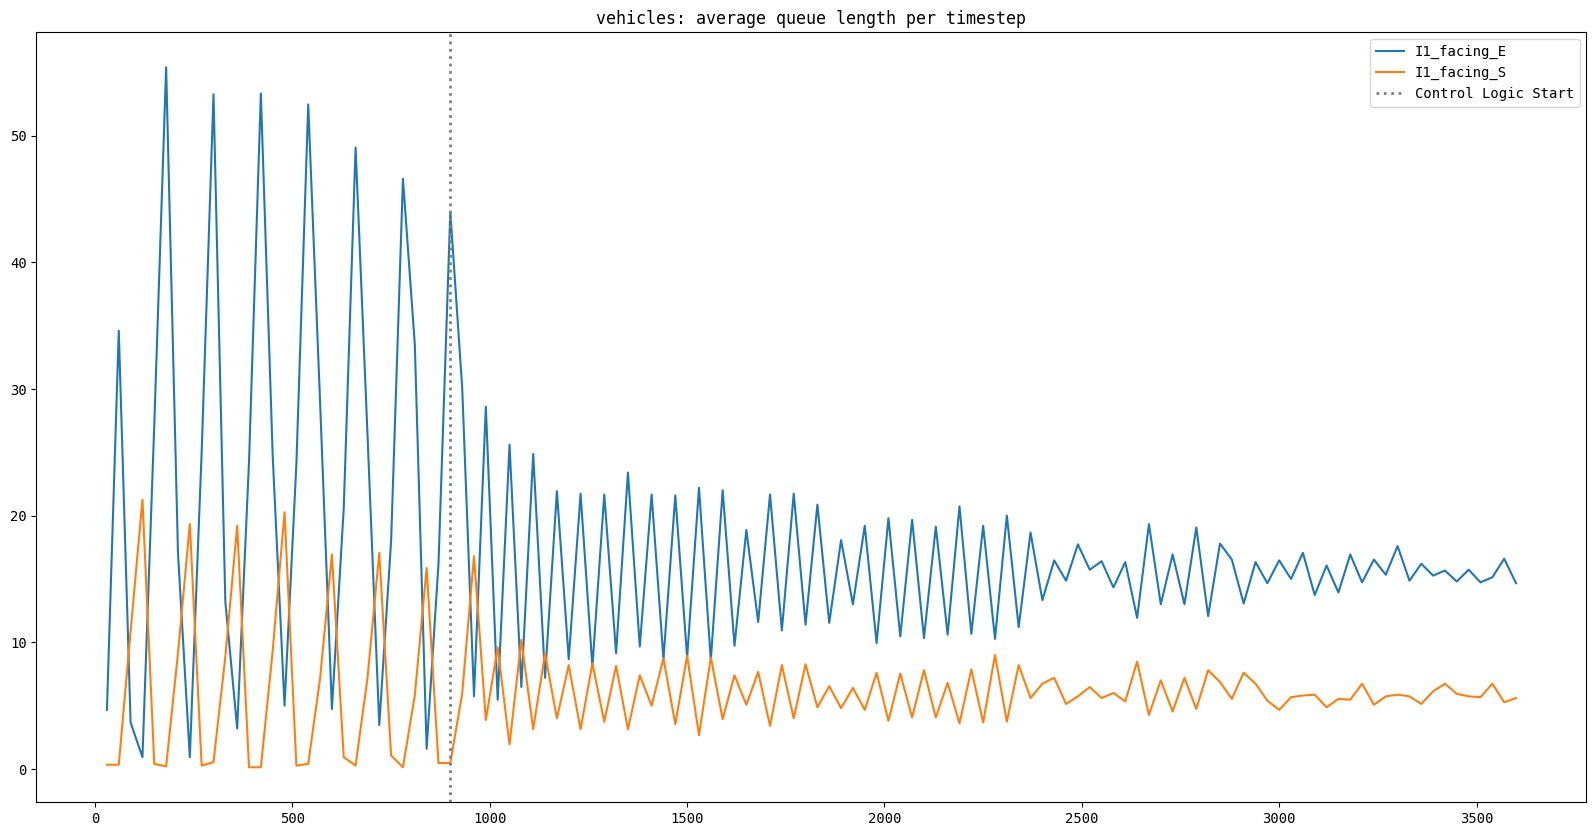

In [36]:
time = np.linspace(30,3600,num_time_steps)
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()
for link in links[8:12]:
    ax.plot(time,average_queue_per_link_per_ts_df[link], label = f"{link}")
plt.title('vehicles: average queue length per timestep')
ax.axvline(x=900, color='grey', linestyle=":", linewidth=2, label='Control Logic Start')

plt.legend()

In [37]:
def trendline(x,y):
    z = np.polyfit(x, y,1)
    p = np.poly1d(z)
    return p(x)

In [42]:
max(average_queue_per_link_per_ts_df["I1_facing_E"][29:])

44.0

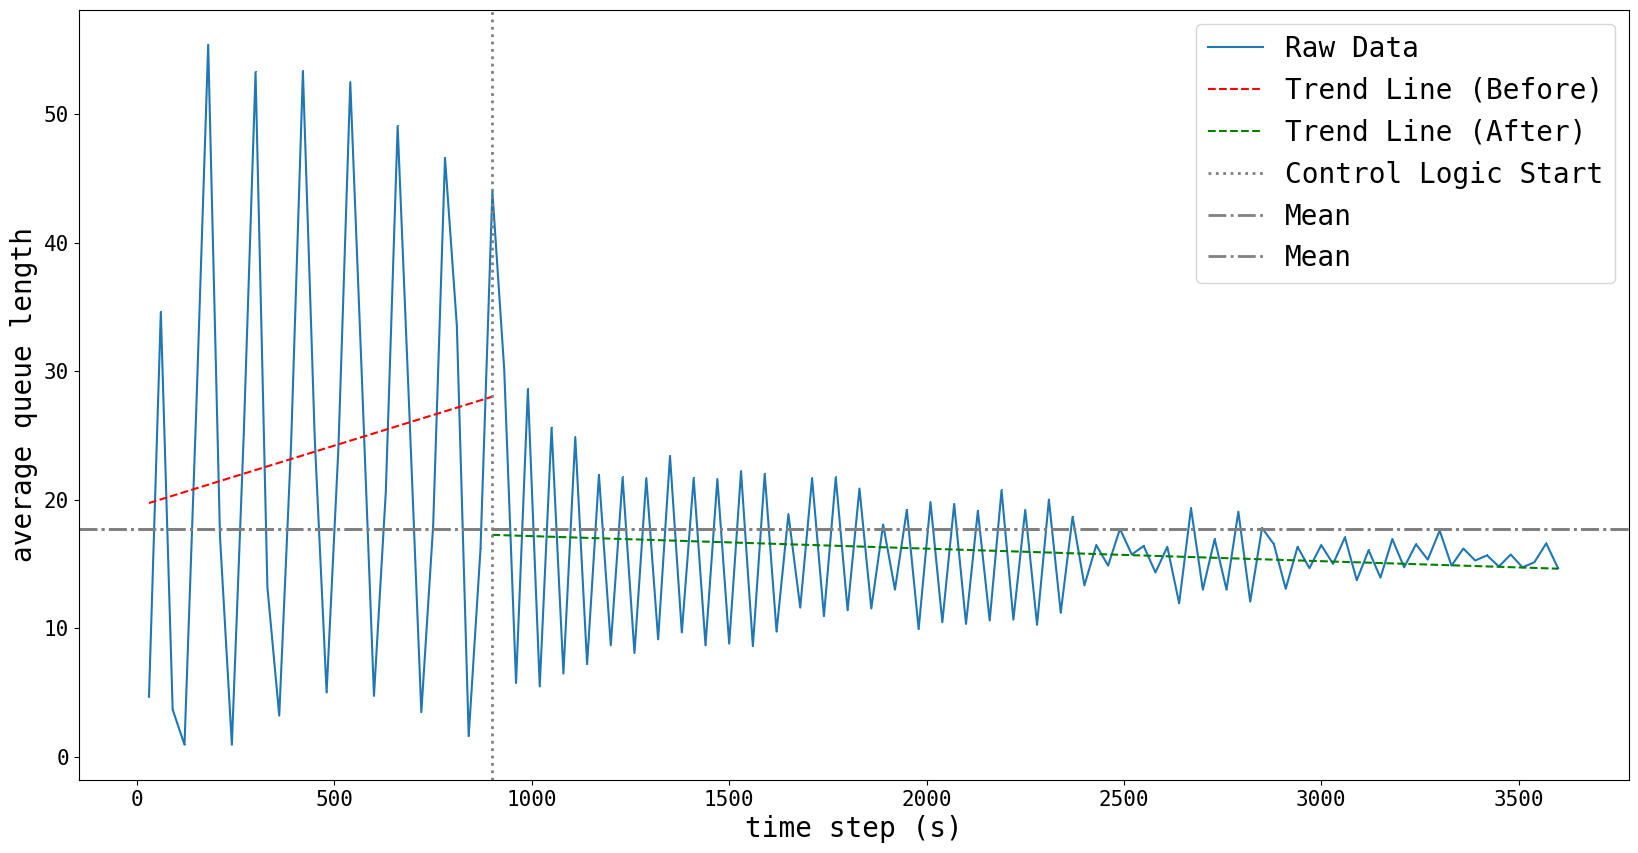

In [38]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

ax.plot(time,average_queue_per_link_per_ts_df["I1_facing_E"],label = "Raw Data", marker = ',')

window_size = 3
qq = average_queue_per_link_per_ts_df["I1_facing_E"].rolling(window=window_size).mean()
# ax.plot(time, qq, label="Rolling Average")

# Fit the trend line before
ax.plot(time[0:30],trendline(time[0:30], average_queue_per_link_per_ts_df["I1_facing_E"][0:30]),"r--", label = "Trend Line (Before)")

# after
ax.plot(time[29:],trendline(time[29:], average_queue_per_link_per_ts_df["I1_facing_E"][29:]),"g--", label = "Trend Line (After)")

ax.axvline(x=900, color='grey', linestyle=":", linewidth=2, label='Control Logic Start')

ax.axhline(y=average_queue_per_link_df["I1_facing_E"][0], color='grey', linestyle="-.", linewidth=2, label='Mean')

ax.axhline(y=average_queue_per_link_df["I1_facing_E"][0], color='grey', linestyle="-.", linewidth=2, label='Mean')


# plt.ylim([10,35])

ax.set_xlabel("time step (s)", fontsize = 27)
ax.set_ylabel("average queue length", fontsize = 27)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize = 20)


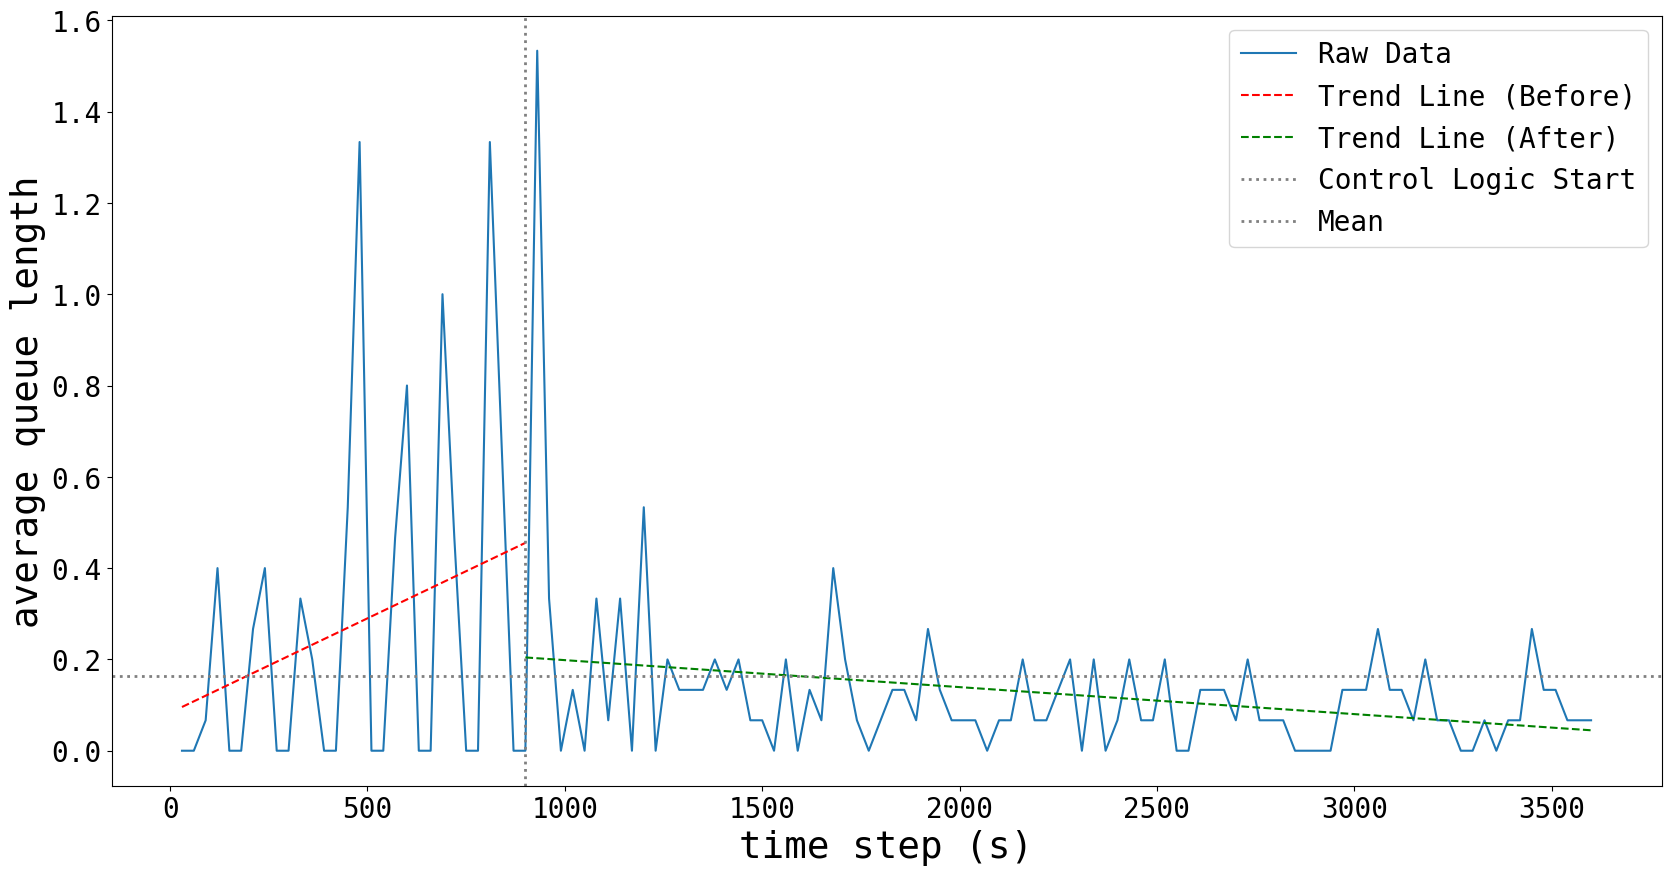

In [39]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

ax.plot(time,average_queue_per_link_per_ts_df["IN_to_PNE"],label = "Raw Data")

window_size = 3
qq = average_queue_per_link_per_ts_df["IN_to_PNE"].rolling(window=window_size).mean()
# ax.plot(time, qq, label="Rolling Average")

# Fit the trend line before
ax.plot(time[0:30],trendline(time[0:30], average_queue_per_link_per_ts_df["IN_to_PNE"][0:30]),"r--", label = "Trend Line (Before)")

# after
ax.plot(time[29:],trendline(time[29:], average_queue_per_link_per_ts_df["IN_to_PNE"][29:]),"g--", label = "Trend Line (After)")

ax.axvline(x=900, color='grey', linestyle=":", linewidth=2, label='Control Logic Start')
ax.axhline(y=average_queue_per_link_df["IN_to_PNE"][0], color='grey', linestyle=":", linewidth=2, label='Mean')

# plt.ylim([0,6])

ax.set_xlabel("time step (s)", fontsize = 27)
ax.set_ylabel("average queue length", fontsize = 27)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize = 20)

In [18]:
average_queue_per_link_per_ts_df

,IE_to_PNE,IW_to_PNW,IE_to_PSE,IW_to_PSW,IN_to_PNW,IN_to_PNE,IS_to_PSW,IS_to_PSE,I1_facing_E,I1_facing_S
0,0.200000,0.200000,0.266667,0.200000,0.000000,0.000000,0.000000,0.000000,4.666667,0.333333
1,0.266667,0.400000,0.400000,0.333333,0.000000,0.000000,0.000000,0.000000,34.600000,0.333333
2,0.000000,0.000000,0.000000,0.000000,0.333333,0.066667,0.133333,0.133333,3.666667,10.866667
3,0.000000,0.000000,0.000000,0.000000,0.333333,0.400000,0.466667,0.133333,0.933333,21.266667
4,0.400000,0.266667,0.266667,0.400000,0.000000,0.000000,0.000000,0.000000,27.200000,0.400000
...,...,...,...,...,...,...,...,...,...,...
115,0.133333,0.000000,0.066667,0.133333,0.000000,0.133333,0.133333,0.200000,15.733333,5.733333
116,0.200000,0.066667,0.000000,0.133333,0.133333,0.133333,0.200000,0.200000,14.733333,5.666667
117,0.133333,0.200000,0.133333,0.000000,0.133333,0.066667,0.200000,0.066667,15.133333,6.733333
118,0.066667,0.133333,0.066667,0.066667,0.200000,0.066667,0.200000,0.133333,16.600000,5.266667


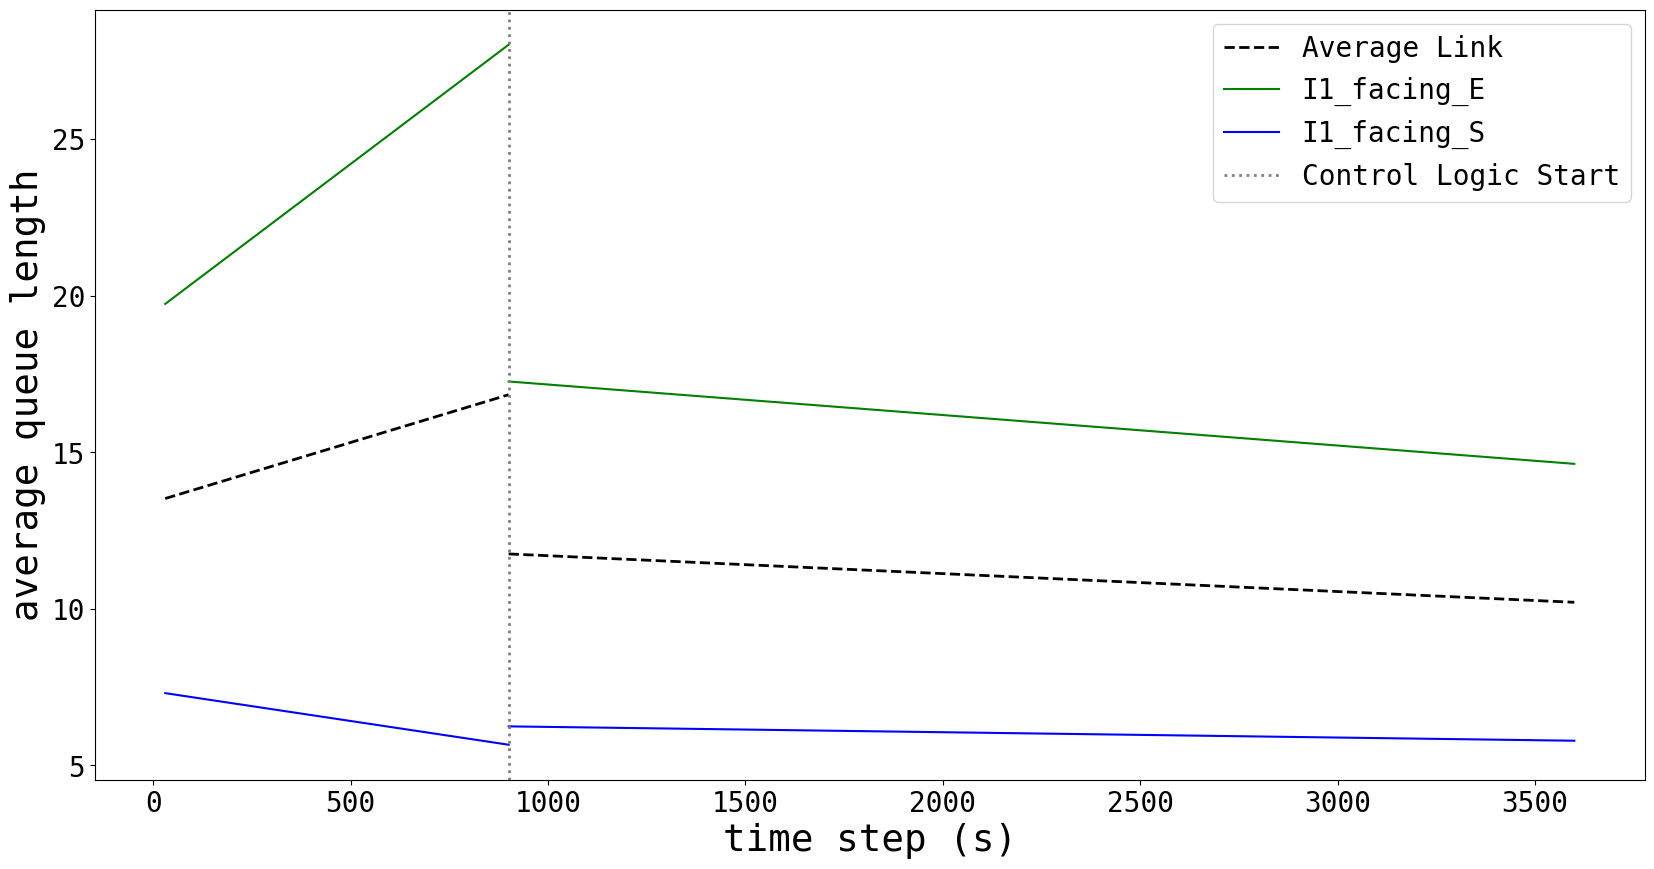

In [40]:
time = np.linspace(30,3600,num_time_steps)

fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

avg = average_queue_per_link_per_ts_df.iloc[:,8:10].sum(axis=1)/2
ax.plot(time[0:30],trendline(time[0:30],avg[0:30]), "k--",label = f"Average Link", linewidth=2)
ax.plot(time[29:],trendline(time[29:],avg[29:]), "k--", linewidth=2)

cc = {"I1_facing_N":"r","I1_facing_S":"b","I1_facing_E":"g","I1_facing_W":"orange"}

for link in links[8:10]:
    ax.plot(time[0:30],trendline(time[0:30], average_queue_per_link_per_ts_df[link][0:30]), color = cc[link], label = f"{link}")
    ax.plot(time[29:],trendline(time[29:], average_queue_per_link_per_ts_df[link][29:]), color = cc[link])


ax.axvline(x=900, color='grey', linestyle=":", linewidth=2, label='Control Logic Start')


ax.set_xlabel("time step (s)", fontsize = 27)
ax.set_ylabel("average queue length", fontsize = 27)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize = 20)

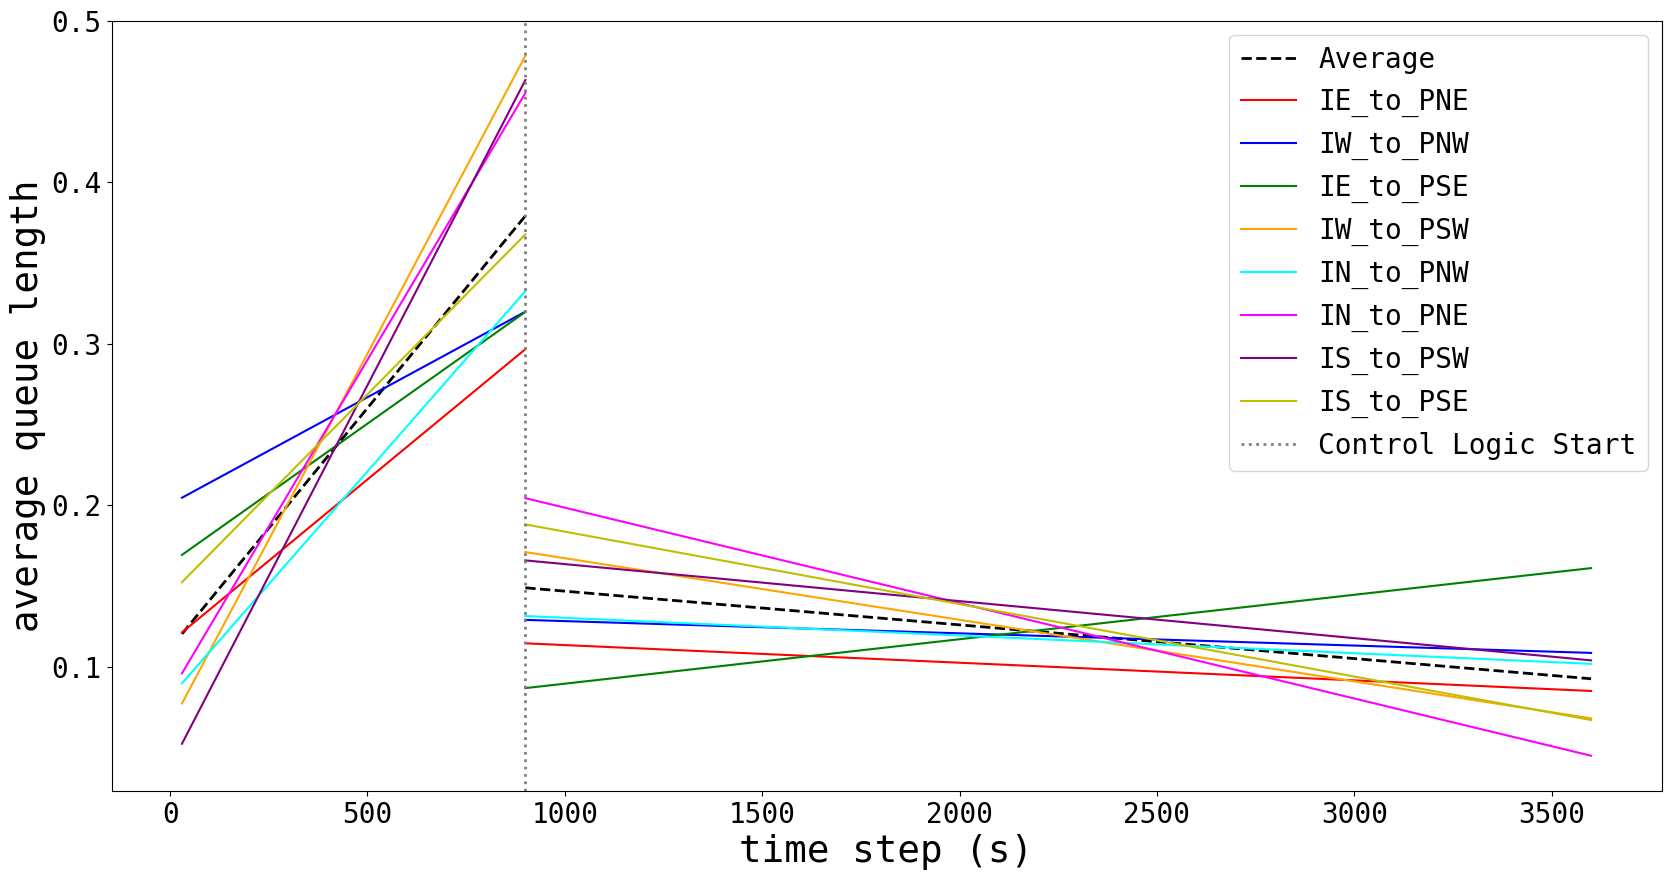

In [46]:
time = np.linspace(30,3600,num_time_steps)

fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

avg = average_queue_per_link_per_ts_df.iloc[:,0:8].sum(axis=1)/8
ax.plot(time[0:30],trendline(time[0:30],avg[0:30]), "k--",label = f"Average", linewidth=2)
ax.plot(time[29:],trendline(time[29:],avg[29:]), "k--", linewidth=2)

cc = {'IE_to_PNE':"r", 'IW_to_PNW':"b", 'IE_to_PSE':"g", 'IW_to_PSW':"orange", 'IN_to_PNW':"cyan",
      'IN_to_PNE':"magenta", 'IS_to_PSW':"purple", 'IS_to_PSE':"y"}

for link in links[0:8]:
    ax.plot(time[0:30],trendline(time[0:30], average_queue_per_link_per_ts_df[link][0:30]), color = cc[link], label = f"{link}")
    ax.plot(time[29:],trendline(time[29:], average_queue_per_link_per_ts_df[link][29:]), color = cc[link])


ax.axvline(x=900, color='grey', linestyle=":", linewidth=2, label='Control Logic Start')


ax.set_xlabel("time step (s)", fontsize = 27)
ax.set_ylabel("average queue length", fontsize = 27)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize = 20, loc="upper right")

In [21]:
average_queue_per_link_df

,IE_to_PNE,IW_to_PNW,IE_to_PSE,IW_to_PSW,IN_to_PNW,IN_to_PNE,IS_to_PSW,IS_to_PSE,I1_facing_E,I1_facing_S
0,0.126111,0.155,0.152222,0.15,0.141111,0.163333,0.166667,0.161667,17.695556,6.180556


### Link Analysis

In [47]:
resultsdf["df_link_summary"][0]

,link,t,arrival_count,departure_count,actual_travel_time,instantanious_travel_time
0,W1I1,0,0,0,23.636364,23.636364
1,W1I1,1,0,0,23.636364,23.636364
2,W1I1,2,1,0,59.000000,23.636364
3,W1I1,3,2,0,58.000000,23.636364
4,W1I1,4,2,0,58.000000,23.636364
...,...,...,...,...,...,...
71995,PSEIE,3595,689,687,37.000000,714.285714
71996,PSEIE,3596,689,687,37.000000,714.285714
71997,PSEIE,3597,689,687,37.000000,714.285714
71998,PSEIE,3598,689,687,37.000000,714.285714


In [48]:
num_runs = len(resultsdf)
num_links_per_ts = len(resultsdf["df_link_summary"][0])

arrival_count_per_link_per_ts = {link: 0 for link in range(num_links_per_ts)}
departure_count_per_link_per_ts = {link: 0 for link in range(num_links_per_ts)}
actual_travel_time_per_link_per_ts = {link: 0 for link in range(num_links_per_ts)}
instantanious_travel_time_per_link_per_ts = {link: 0 for link in range(num_links_per_ts)}

for run in range(num_runs):
    q_cl = resultsdf['df_link_summary'][run]
    for link in range(num_links_per_ts):
        arrival_count_per_link_per_ts[link] += q_cl['arrival_count'][link]/num_runs
        departure_count_per_link_per_ts[link] += q_cl['departure_count'][link]/num_runs
        actual_travel_time_per_link_per_ts[link] += q_cl['actual_travel_time'][link]/num_runs
        instantanious_travel_time_per_link_per_ts[link] += q_cl['instantanious_travel_time'][link]/num_runs

link_ = resultsdf["df_link_summary"][0]["link"].values
timestep = resultsdf["df_link_summary"][0]["t"].values

col_names = resultsdf["df_link_summary"][0].columns.values

data = [link_, timestep, arrival_count_per_link_per_ts,departure_count_per_link_per_ts,
        actual_travel_time_per_link_per_ts,instantanious_travel_time_per_link_per_ts]

data_dict = {column: dd for column, dd in zip(col_names, data)}
index = resultsdf["df_link_summary"][0].index.values

average_link_data_df = pd.DataFrame(data = data_dict, index = index) 

In [49]:
average_link_data_df = average_link_data_df[~average_link_data_df["link"].str.startswith("I")]

instant_travel_times = {"W1I1":23.636364, "E1I1":23.636364, "N1I1": 8.181818182, "S1I1": 8.181818182,
                        "PNEIE": 7.142857143,"PNEIN": 7.142857143,"PNWIN": 7.142857143,"PNWIW": 7.142857143,
                       "PSEIE": 7.142857143,"PSEIS": 7.142857143,"PSWIS": 7.142857143,"PSWIW": 7.142857143}
average_link_data_df['free_flow_time'] = average_link_data_df['link'].map(instant_travel_times)
average_link_data_df["travel_delay"] = average_link_data_df["actual_travel_time"]-average_link_data_df["free_flow_time"]

In [50]:
average_link_data_df_before = average_link_data_df.iloc[np.where(average_link_data_df["t"]<=900)]
average_link_data_df_after = average_link_data_df.iloc[np.where(average_link_data_df["t"]>900)]

average_travel_time_before = np.sum(average_link_data_df_before["actual_travel_time"])/len(average_link_data_df_before)
average_travel_delay_before = np.sum(average_link_data_df_before["travel_delay"])/len(average_link_data_df_before)

average_travel_time_after = np.sum(average_link_data_df_after["actual_travel_time"])/len(average_link_data_df_after)
average_travel_delay_after = np.sum(average_link_data_df_after["travel_delay"])/len(average_link_data_df_after)

In [54]:
print("BEFORE: The average travel time is ", average_travel_time_before, "s and the average delay time is", average_travel_delay_before, "s")

BEFORE: The average travel time is  31.70751824572024 s and the average delay time is 22.811414313120245 s


In [55]:
print("AFTER: The average travel time is ", average_travel_time_after, "s and the average delay time is", average_travel_delay_after, "s")

AFTER: The average travel time is  20.273856984068175 s and the average delay time is 11.377753051468172 s


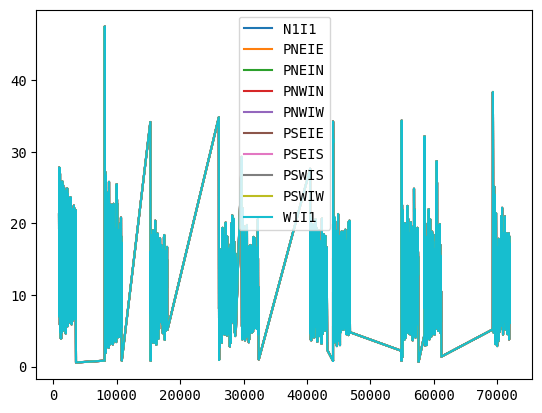

In [53]:
linknames = np.unique(average_link_data_df["link"].values)
for link in linknames:
    plt.plot(average_link_data_df_after["travel_delay"],label=f"{link}")
plt.legend()

### OD analysis

In [22]:
num_runs = len(resultsdf)
num_ods = len(resultsdf["df_od_summary"][0])

total_trips_per_od = {od: 0 for od in range(num_ods)}
total_completed_trips_per_od = {od: 0 for od in range(num_ods)}
average_travel_time_per_od = {od: 0 for od in range(num_ods)}
variance_travel_time_per_od = {od: 0 for od in range(num_ods)}
average_distance_traveled_per_veh_per_od = {od: 0 for od in range(num_ods)}
variance_distance_traveled_per_veh_per_od = {od: 0 for od in range(num_ods)}

for run in range(num_runs):
    q_od = resultsdf['df_od_summary'][run]
    for od in range(num_ods):
        total_trips_per_od[od] += q_od['total_trips'][od]/num_runs
        total_completed_trips_per_od[od] += q_od['completed_trips'][od]/num_runs
        average_travel_time_per_od[od] += (q_od['average_travel_time'][od])/num_runs
        variance_travel_time_per_od[od] += (q_od['stddiv_travel_time'][od])**2/num_runs
        average_distance_traveled_per_veh_per_od[od] += q_od['average_distance_traveled_per_veh'][od]/num_runs
        variance_distance_traveled_per_veh_per_od[od] += (q_od['stddiv_distance_traveled_per_veh'][od])**2/num_runs

origin = resultsdf["df_od_summary"][0]["orig"].values
destination = resultsdf["df_od_summary"][0]["dest"].values
free_travel_time = resultsdf["df_od_summary"][0]["free_travel_time"].values
shortest_distance = resultsdf["df_od_summary"][0]["shortest_distance"].values
col_names = resultsdf["df_od_summary"][0].columns.values

data = [origin,destination,total_trips_per_od,total_completed_trips_per_od,
       free_travel_time,average_travel_time_per_od,variance_travel_time_per_od,
       shortest_distance,average_distance_traveled_per_veh_per_od,variance_distance_traveled_per_veh_per_od]

data_dict = {column: dd for column, dd in zip(col_names, data)}
index = resultsdf["df_od_summary"][0].index.values

average_od_data_df = pd.DataFrame(data = data_dict, index = index) 

In [23]:
average_od_data_df # averaged across all 30 runs

,orig,dest,total_trips,completed_trips,free_travel_time,average_travel_time,stddiv_travel_time,shortest_distance,average_distance_traveled_per_veh,stddiv_distance_traveled_per_veh
0,W1,E1,1677.266667,1650.333333,47.272727,60.450567,202.850841,520.0,463.914416,349.846151
1,W1,S1,1310.666667,1286.800000,31.818182,55.212386,179.806882,350.0,407.735021,279.137085
2,N1,S1,705.533333,699.933333,16.363636,34.261975,192.975844,180.0,236.491007,85.117995
3,N1,E1,478.533333,474.200000,31.818182,39.316176,203.663138,350.0,292.864253,195.553818
4,PNW,PNE,344.266667,339.333333,14.285714,46.566378,801.816837,20.0,32.445373,128.034280
5,PNW,PSW,346.133333,342.533333,14.285714,36.503422,589.874311,20.0,26.284181,88.887676
6,PNW,PSE,330.000000,326.533333,28.571429,41.574642,640.644423,40.0,29.254196,111.494245
7,PNE,PSW,361.933333,358.400000,28.571429,44.092221,676.958699,40.0,30.387401,83.757581
8,PNE,PNW,342.200000,339.600000,14.285714,37.643690,605.839764,20.0,26.355545,92.393969
9,PNE,PSE,317.933333,313.866667,14.285714,44.774500,679.693388,20.0,31.341155,133.008206


### Basic Metrics

In [24]:
num_runs = len(resultsdf)

total_trips = 0
completed_trips = 0
total_travel_time = 0
average_travel_time = 0
total_delay = 0
average_delay = 0

for run in range(num_runs):
    q_met = resultsdf['df_metrics'][run]
    total_trips += q_met['total_trips']/num_runs
    completed_trips += q_met['completed_trips']/num_runs
    total_travel_time += q_met['total_travel_time']/num_runs
    average_travel_time += q_met['average_travel_time']/num_runs
    total_delay += q_met['total_delay']/num_runs
    average_delay += q_met['average_delay']/num_runs
    
col_names = resultsdf["df_metrics"][0].columns.values

data = [total_trips,completed_trips,total_travel_time,average_travel_time,total_delay,average_delay]

data_dict = {column: dd for column, dd in zip(col_names, data)}
index = [0]

average_met_data_df = pd.DataFrame(data = data_dict, index = index) 

In [25]:
average_met_data_df

,total_trips,completed_trips,total_travel_time,average_travel_time,total_delay,average_delay
0,8246.866667,8141.666667,385463.466667,47.345033,160359.743723,19.696385


### Computation Time

In [26]:
runtimes;

avg_sim_runtime = np.mean(runtimes)
print("the average runtime for a simulation is",avg_sim_runtime, "s")

the average runtime for a simulation is 52.46854496002197 s


In [27]:
num_runs = len(resultsdf)

avg_mpc_runtime = 0

for run in range(num_runs):
    avg_mpc_runtime += np.mean(resultsdf["mpc_comp_times"][run])/num_runs

print("the average runtime for a simulation is",avg_mpc_runtime,"s")

the average runtime for a simulation is 0.3038696868331344 s


In [28]:
num_runs = len(resultsdf)
num_time_steps = len(resultsdf["mpc_comp_times"][0])

average_mpc_comp_time = {ts: 0 for ts in range(num_time_steps)}

for run in range(num_runs):
    q_mpc = resultsdf['mpc_comp_times'][run]
    for ts in range(num_time_steps):
        average_mpc_comp_time[ts] += q_mpc[ts]/num_runs
    
average_mpc_comp_time_df = pd.DataFrame.from_dict(average_mpc_comp_time, orient='index')

In [29]:
0.49780828687879775-average_mpc_comp_time_df[0].mean()

np.float64(0.19393860004566332)

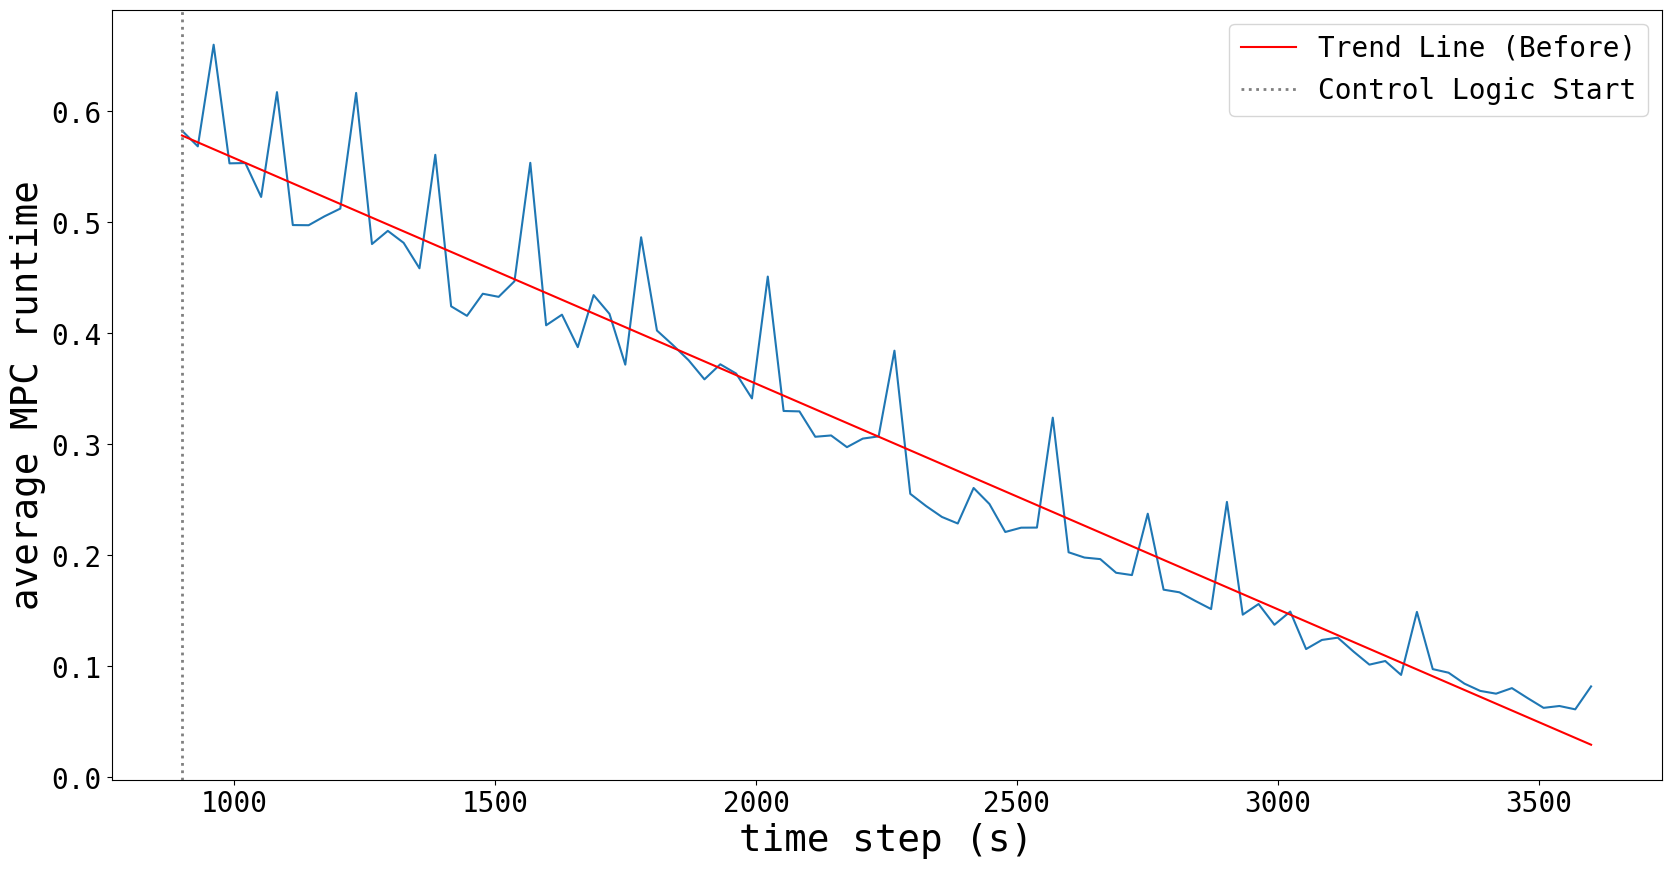

In [32]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

time = np.linspace(900,3600,len(average_mpc_comp_time_df))
ax.plot(time,average_mpc_comp_time_df)
ax.plot(time, trendline(time, average_mpc_comp_time_df[0] ),"r", label = "Trend Line (Before)")

ax.axvline(x=900, color='grey', linestyle=":", linewidth=2, label='Control Logic Start')

ax.set_xlabel("time step (s)", fontsize = 27)
ax.set_ylabel("average MPC runtime", fontsize = 27)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize = 20)